In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

 # linear algebra
 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers, applications, callbacks
from tensorflow.keras.applications import DenseNet121  
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import tensorflow.keras.preprocessing.image as tf_image
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
train = pd.read_csv('/kaggle/input/facial-keypoints-detection/training.zip')
test = pd.read_csv('/kaggle/input/facial-keypoints-detection/test.zip')
idlookup_data = pd.read_csv('/kaggle/input/facial-keypoints-detection/IdLookupTable.csv')

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [5]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [7]:
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [9]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [10]:
train_image = train.Image
train = train.drop('Image', axis=1)


In [11]:
t1 = train.iloc[:2000, :]
t2 = train.iloc[2000:4000, :]
t3 = train.iloc[4000:6000, :]
t4 = train.iloc[6000: , :]
print(t1.isnull().sum())
print('\n', '--------------------------------', '\n')
print(t2.isnull().sum())
print('\n', '--------------------------------', '\n')
print(t3.isnull().sum())
print('\n', '--------------------------------', '\n')
print(t4.isnull().sum())

left_eye_center_x             4
left_eye_center_y             4
right_eye_center_x            7
right_eye_center_y            7
left_eye_inner_corner_x       6
left_eye_inner_corner_y       6
left_eye_outer_corner_x       5
left_eye_outer_corner_y       5
right_eye_inner_corner_x      8
right_eye_inner_corner_y      8
right_eye_outer_corner_x     10
right_eye_outer_corner_y     10
left_eyebrow_inner_end_x      5
left_eyebrow_inner_end_y      5
left_eyebrow_outer_end_x     27
left_eyebrow_outer_end_y     27
right_eyebrow_inner_end_x     7
right_eyebrow_inner_end_y     7
right_eyebrow_outer_end_x    25
right_eyebrow_outer_end_y    25
nose_tip_x                    0
nose_tip_y                    0
mouth_left_corner_x          10
mouth_left_corner_y          10
mouth_right_corner_x         11
mouth_right_corner_y         11
mouth_center_top_lip_x        6
mouth_center_top_lip_y        6
mouth_center_bottom_lip_x    19
mouth_center_bottom_lip_y    19
dtype: int64

 -------------------------

In [12]:
train_img = train_image.apply( lambda x: np.fromstring(x, dtype=float, sep=' ').reshape(96, 96) )

# type(train_img[0])
train_img[0].shape

(96, 96)

In [13]:

train_data = np.array(train).reshape(7049, 15,2)


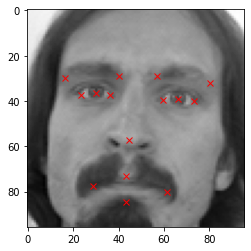

In [14]:
plt.imshow(train_img[0], cmap='gray')
plt.plot(train_data[0][:, 0], train_data[0][:, 1], 'rx')

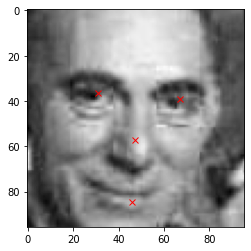

In [15]:
plt.imshow(train_img[7048], cmap='gray')
plt.plot(train_data[7048][:, 0], train_data[0][:, 1], 'rx')

In [16]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b


# Augmentation

#### Horizontal and Vertical Flip

In [17]:
def horizontal_flip(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    image2 = np.flip(image1, axis=1)
    keypoints1[:, 0] = 96-keypoints1[:, 0]
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    
    return s

def vertical_flip(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    image2 = np.flip(image1, axis=0)
    keypoints1[:, 1] = 96-keypoints1[:, 1]
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    
    return s


#### Display Function

In [18]:
def display(image, keypoints=[]):
    plt.figure()
    plt.imshow(image, cmap='gray')
    if len(keypoints)>0:
        plt.plot(keypoints[:, 0], keypoints[:, 1], 'rx')
    
def compare(image1, keypoints1, image2, keypoints2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image1, cmap='gray')
    plt.plot(keypoints1[:, 0], keypoints1[:, 1], 'rx')
    
    plt.subplot(1,2,2)
    plt.imshow(image2, cmap='gray')
    plt.plot(keypoints2[:, 0], keypoints2[:, 1], 'rx')
    
    
def df_plot(df):
    fig = plt.figure(figsize=(24,24))
    for i in range(6):
        ax = fig.add_subplot(1, 6, i+1)
        image = plt.imshow(df['Image'][i], cmap = 'gray')
        n = int(df.iloc[i][:-1].shape[0]) + 1
        for j in range(1, n, 2):
            plt.plot(df.loc[i][j-1], df.loc[i][j], 'rx')

#### Rotation

In [19]:
def rotation(df, col):  
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    angle = np.random.uniform(-60, 60)
    h,w = 96, 96
    cX, cY = 48, 48
    
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1)
    
    #  
    #  (rot_mat) M =  [ m00    m01  m02]   = [ cosx    sinx  (1−cosx)cX − sinx*cY ]
    #                 [m10    m11  m12]      [-sinx   cosx   sinx*cX + (1−cosx)cY ]     
    #
    
    cos = np.abs(M[0][0])
    sin = np.abs(M[0][1])

    #     nW = int(h*sin + w*cos)
    #     nH = int(w*sin + h*cos)
    
    nW = 96
    nH = 96

    #     M[0, 2] += (nW / 2) - cX
    #     M[1, 2] += (nH / 2) - cY
    
    r_img = cv2.warpAffine(image1, M, (nW, nH))
    
    keypoints1[:, 0] = keypoints1[:, 0] - cX
    keypoints1[:, 1] = keypoints1[:, 1] - cY

    r_angl = np.radians(angle)
    cos = np.cos(r_angl)
    sin = np.sin(r_angl)

    M2 = np.array([[cos, sin],
                  [-sin, cos]])
    
    r_keypoints = np.dot(M2, keypoints1.T)
    r_keypoints = r_keypoints.T
    r_keypoints[:, 0] = r_keypoints[:, 0] + (nW)/2.0
    r_keypoints[:, 1] = r_keypoints[:, 1] + (nH)/2.0
    
    keypoints2 = r_keypoints.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = r_img
    
    return s
    


#### Brightness

In [20]:
def brightness(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    image2 = np.clip(np.random.uniform(0.1, 3)*image1, 0.0, 255.0)
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    
    return s


##### Shift

In [21]:
def shift(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    tx = np.random.uniform(-10, 10)
    ty = np.random.uniform(-10, 10)
    
    M = np.array([[1, 0, tx],
                  [0, 1, ty]])
    
    image2 = cv2.warpAffine(image1, M, (96, 96))
    
    keypoints1[:, 0] = keypoints1[:, 0] + tx 
    keypoints1[:, 1] = keypoints1[:, 1] + ty 
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    return s



#### Noise and Blur

In [22]:
def noise(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    image2 = cv2.add(image1, np.random.uniform(0.1,0.9)*np.random.randint(50, size=(96,96)))
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    return s




In [23]:
def blur(df, col):
    image, keypoints = df[-1:], df[:-1]
    image1 = np.array(image)[0]
    n = int(keypoints.shape[0]/2)
    keypoints1 = np.array(keypoints).reshape(-1, n, 2)[0]
    
    image2 = cv2.GaussianBlur(image1, (5,5), 0)
    
    keypoints2 = keypoints1.reshape(-1, 2*n)[0]
    s = pd.Series(keypoints2, index=col[:-1])
    s['Image'] = image2
    return s



In [24]:
df = pd.read_csv('/kaggle/input/facial-keypoints-detection/training.zip')

In [25]:
df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, dtype=float, sep=' ').reshape(96,96))

In [26]:
d_df = df[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']]
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   nose_tip_x                 7049 non-null   float64
 5   nose_tip_y                 7049 non-null   float64
 6   mouth_center_bottom_lip_x  7016 non-null   float64
 7   mouth_center_bottom_lip_y  7016 non-null   float64
 8   Image                      7049 non-null   object 
dtypes: float64(8), object(1)
memory usage: 495.8+ KB


In [27]:
d_df = d_df.dropna()
d_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [28]:
d_df.shape

(7000, 9)

In [29]:
d_tf = d_df.copy()
d_tf.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,44.420571,57.066803,43.130707,84.485774,"[[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 23..."


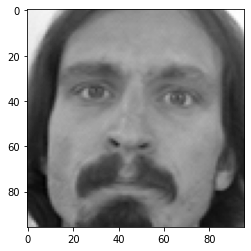

In [30]:
display(d_tf.iloc[0, -1])

In [31]:
dtf = d_tf.sample(frac=1).reset_index(drop=True)
dcol = dtf.columns

In [32]:
dcol

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [33]:

dtf1 = dtf.iloc[:3000].copy()
dtf2 = dtf.iloc[3000:6000].copy()



In [34]:
dtf1 = dtf1.apply(lambda row: horizontal_flip(row, dcol), axis=1)
dtf2 = dtf2.apply(lambda row: vertical_flip(row, dcol), axis=1)

dtf = pd.concat([dtf,dtf1, dtf2], ignore_index=True)

In [35]:
dtf = dtf.sample(frac=1).reset_index(drop=True)
dtf.shape

(13000, 9)

In [36]:
n = int(len(dtf)/2)
dtf3 = dtf.iloc[:n].copy()
dtf3 = dtf3.apply(lambda row: rotation(row, dcol), axis=1)
dtf = pd.concat([dtf, dtf3], ignore_index=True)

In [37]:
dtf = dtf.sample(frac=1).reset_index(drop=True)
dtf.shape

(19500, 9)

In [38]:
n1 = int(len(dtf)/4)

dtf4 = dtf.iloc[:n1].copy()
dtf5 = dtf.iloc[n1:2*n1].copy()
dtf6 = dtf.iloc[2*n1:3*n1].copy()
dtf7 = dtf.iloc[3*n1:].copy()

In [39]:
dtf4 = dtf4.apply(lambda row: brightness(row, dcol), axis=1)
dtf5 = dtf5.apply(lambda row: noise(row, dcol), axis=1)
dtf6 = dtf6.apply(lambda row: blur(row, dcol), axis=1)
dtf7 = dtf7.apply(lambda row: shift(row, dcol), axis=1)


dtf = pd.concat([dtf,dtf4, dtf5, dtf6, dtf7], ignore_index=True)

In [40]:
dtf.shape

(39000, 9)

# Model

In [41]:
model = Sequential()

pretrained_model = applications.MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model.add(layers.LeakyReLU(alpha = 0.1))
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8))
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 8200      
Total params: 3,237,070
Trainable params: 3,215,182
Non-t

In [42]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [43]:
img = dtf.iloc[:, -1]
img = img/255.0
X = np.empty((len(img), 96, 96, 1))

for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)

X = np.asarray(X).astype(np.float32)
X.shape

(39000, 96, 96, 1)

In [44]:
y = dtf.iloc[:,:-1]
y = np.asarray(y).astype(np.float32)
y.shape

(39000, 8)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [46]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05)

Epoch 1/100
124/124 [==============================] - 35s 207ms/step - loss: 1129.0993 - accuracy: 0.5718 - val_loss: 213.0232 - val_accuracy: 0.8848
Epoch 2/100
124/124 [==============================] - 24s 195ms/step - loss: 95.4271 - accuracy: 0.8885 - val_loss: 92.5572 - val_accuracy: 0.9065
Epoch 3/100
124/124 [==============================] - 24s 196ms/step - loss: 71.8418 - accuracy: 0.9077 - val_loss: 109.7853 - val_accuracy: 0.9011
Epoch 4/100
124/124 [==============================] - 24s 197ms/step - loss: 59.0458 - accuracy: 0.9209 - val_loss: 72.1767 - val_accuracy: 0.8842
Epoch 5/100
124/124 [==============================] - 24s 194ms/step - loss: 49.4095 - accuracy: 0.9250 - val_loss: 87.9035 - val_accuracy: 0.9324
Epoch 6/100
124/124 [==============================] - 24s 196ms/step - loss: 41.6365 - accuracy: 0.9307 - val_loss: 65.3781 - val_accuracy: 0.9198
Epoch 7/100
124/124 [==============================] - 24s 194ms/step - loss: 48.2321 - accuracy: 0.9266 - v

In [47]:
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

183/183 [==============================] - 1s 8ms/step - loss: 32.5329 - accuracy: 0.9537
Accuracy : 0.9536752104759216


In [48]:
# Getting the model history keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

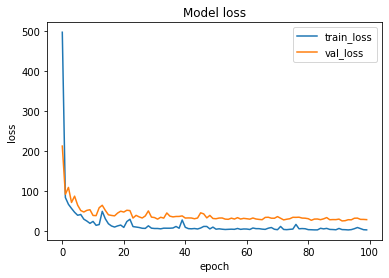

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [50]:
df_predict = model.predict(X_test)

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 5.7037614023135195


In [51]:

df_predict= pd.DataFrame(df_predict)
df_predict.head()

,0,1,2,3,4,5,6,7
0,66.950241,41.526379,29.915636,39.429996,45.534584,66.414177,45.433090,78.696342
1,57.990017,43.503101,22.090342,51.174713,39.691177,66.742966,45.730743,90.599960
2,50.798599,33.127090,25.600693,67.694984,57.020271,68.901543,75.178146,79.495323
3,30.397089,36.374565,66.629265,37.869274,47.242794,64.989319,46.845753,78.231781
4,65.764175,35.260334,30.619673,37.770832,46.627613,59.946087,48.266361,79.935715


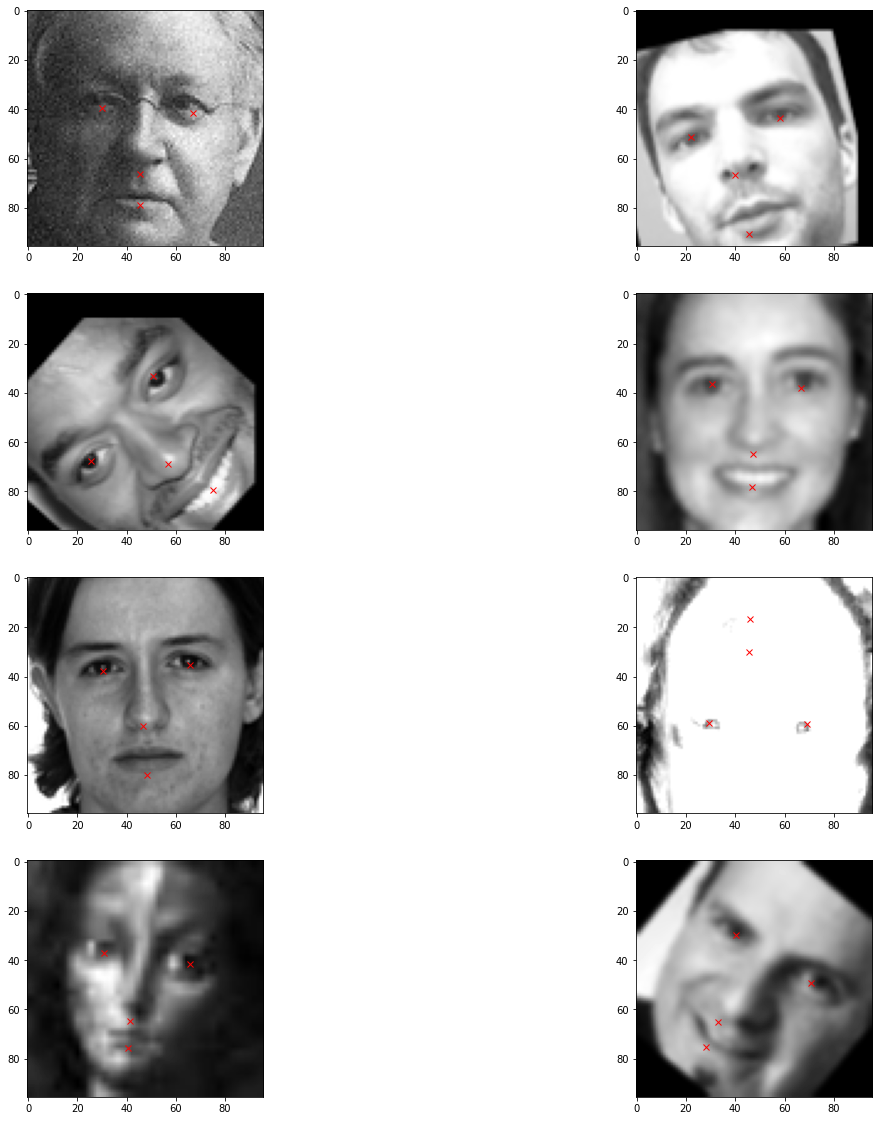

In [52]:

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,9,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

In [53]:
test_image = test.iloc[:, -1].copy()

In [54]:
test_image

0       182 183 182 182 180 180 176 169 156 137 124 10...
1       76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2       177 176 174 170 169 169 168 166 166 166 161 14...
3       176 174 174 175 174 174 176 176 175 171 165 15...
4       50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
                              ...                        
1778    101 101 101 100 100 97 97 98 102 149 214 206 1...
1779    201 191 171 158 145 140 136 130 123 115 108 10...
1780    28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781    104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...
1782    63 61 64 66 66 64 65 70 69 70 77 83 63 34 22 2...
Name: Image, Length: 1783, dtype: object

In [55]:
test_image = test_image.apply(lambda x: np.fromstring(x, dtype=float, sep=' ').reshape(96, 96))

In [56]:
test_image

0       [[182.0, 183.0, 182.0, 182.0, 180.0, 180.0, 17...
1       [[76.0, 87.0, 81.0, 72.0, 65.0, 59.0, 64.0, 76...
2       [[177.0, 176.0, 174.0, 170.0, 169.0, 169.0, 16...
3       [[176.0, 174.0, 174.0, 175.0, 174.0, 174.0, 17...
4       [[50.0, 47.0, 44.0, 101.0, 144.0, 149.0, 120.0...
                              ...                        
1778    [[101.0, 101.0, 101.0, 100.0, 100.0, 97.0, 97....
1779    [[201.0, 191.0, 171.0, 158.0, 145.0, 140.0, 13...
1780    [[28.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34...
1781    [[104.0, 95.0, 71.0, 57.0, 46.0, 52.0, 65.0, 7...
1782    [[63.0, 61.0, 64.0, 66.0, 66.0, 64.0, 65.0, 70...
Name: Image, Length: 1783, dtype: object

In [57]:
imgt = test_image
imgt = imgt/255.0

# Create an empty array of shape (32k, 96, 96, 1) to train the model
Xt = np.empty((len(imgt), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array 
# Note that we need to expand it's dimension from (96,96) to (96,96,1)
for i in range(len(imgt)):
    Xt[i,] = np.expand_dims(imgt[i], axis = 2)

# Convert the array type to float32
Xt = np.asarray(Xt).astype(np.float32)
Xt.shape

(1783, 96, 96, 1)

In [58]:
test_preds = model.predict(Xt)

In [59]:
pd.DataFrame(test_preds).to_csv('test_preds4_2.csv',index = False)

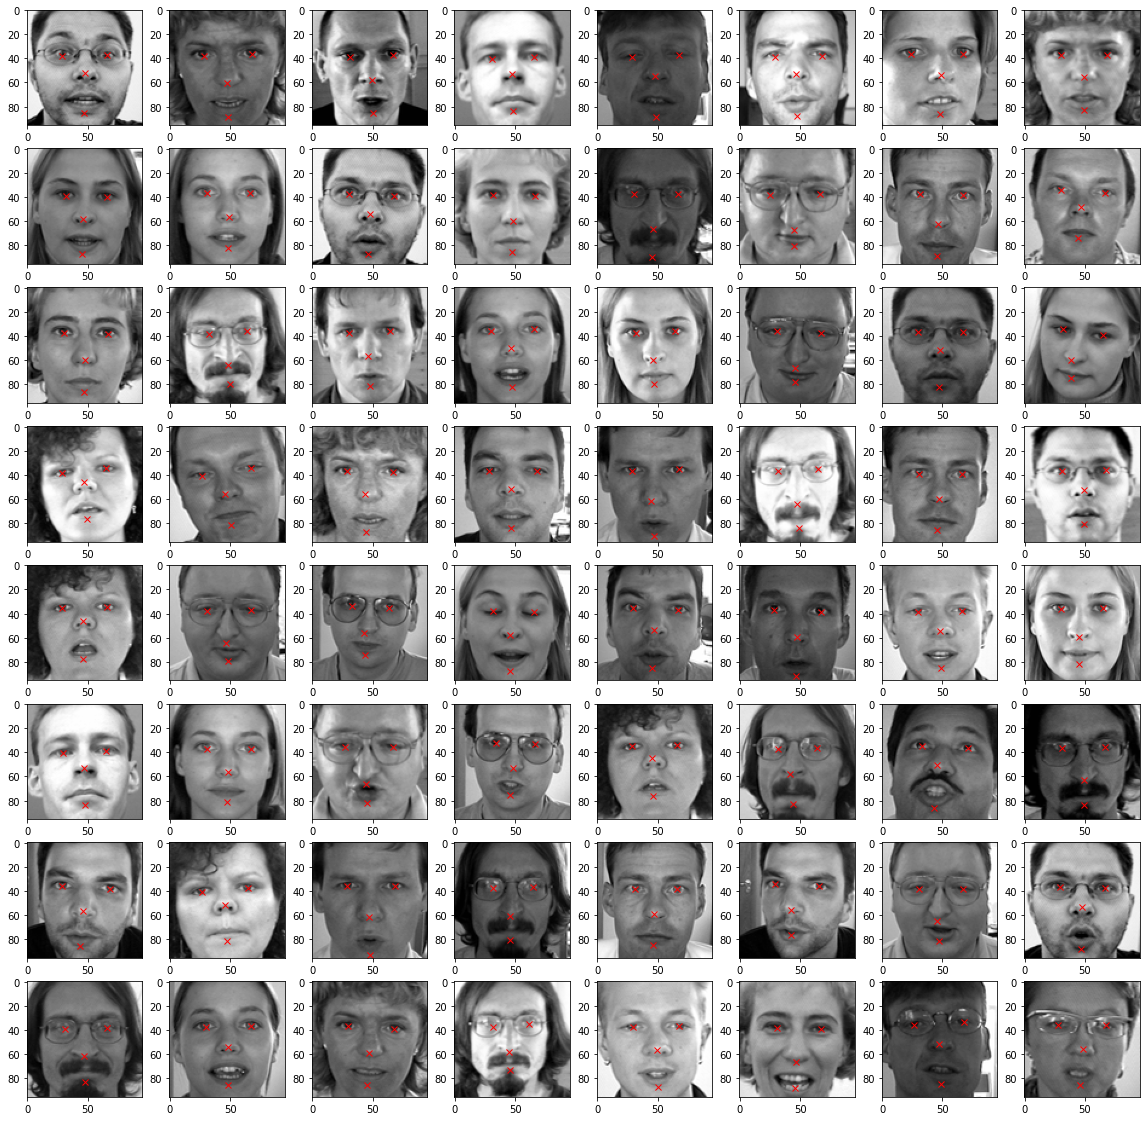

In [60]:
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(Xt[i].reshape(96,96), cmap = 'gray')
    for j in range(1,9,2):
        plt.plot(test_preds[i][j-1], test_preds[i][j], 'rx')
    